# Link prediction challenge

We are using graph-tool (only available in Mac/Linux) and pytorch/dgl (sometimes hard to install). To make sure everything works let's run it on google colab
[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jgarciab/NetworkScience/blob/main/Practicals/day3/day3b_link_prediction.ipynb) 

In [40]:
## If you are running this on your computer you can install the libraries uncommenting these lines
## Don't mix installations with conda and installations with pip (bad practice)
# conda install -c conda-forge graph-tool
# conda install -c pytorch pytorch
# conda install -c dglteam dgl
# mamba install "scipy<1.13" #required for node2vec

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install() # expect a kernel restart

In [5]:
# Install graph-tool 
!wget https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!dpkg -i skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!echo "deb [signed-by=/usr/share/keyrings/skewed-keyring.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

In [6]:
# Install node2vec to create embeddings
!pip install scipy==1.12
!pip install -U gensim
!pip install node2vec

In [ ]:
# It should be in this order
!mamba install -c dglteam dgl

In [4]:
# networks
import networkx as nx
import graph_tool.all as gt
from graph_tool import topology, inference, generation, stats, correlations, clustering

# machine learning
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import RocCurveDisplay

# embeddings
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA, TruncatedSVD, NMF

# Some math
import scipy.sparse as sp
import numpy as np
from numpy.linalg import inv

# data wrangling
import pandas as pd
from itertools import permutations, combinations, product

# viz
import pylab as plt

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [5]:
# path_data = "../../Data/"
#Don't change this on colab
path_data = "./"

## 1. Read network
We are going to use a protein-protein interaction network from S. cervisiae (the yeast that is used to make beer, bread and all sort of yummy things): http://interactome.dfci.harvard.edu/S_cerevisiae/download/YuSci2008.pdf


__You can also try predicting in the Twitter network by editing the network (write "twitter" instead of "ppi")__
```

In [67]:
network = "ppi"

# Read network (download it from internet) 
## ONLY IN COLAB! (otherwise use the data from the Data folder, no need to download)
!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/{network}_network_prediction.graphml 
!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/{network}_network_prediction_test.csv

# Path network
path_network = f"{path_data}/{network}_network_prediction.graphml"

# Read to networkx, this allows us to use the networkx functions
if network == "ppi":
    G = nx.read_graphml(path_network, node_type=int)
else:
    G = nx.read_graphml(path_network)
    
# Read to graph-tool, this allows us to use the graph-tool functions
g = gt.load_graph(path_network)
num_vertices = g.num_vertices()

# The node names in graph-tool are different from the ones in networkx
# let's create a dictionary to map graph-tool node labels to networkx node labels
if network == "ppi":
    gt_to_networkx_labels = dict((i, int(g.vp['_graphml_vertex_id'][i])) for i in range(g.num_vertices()))
else:
    gt_to_networkx_labels = dict((i, g.vp['_graphml_vertex_id'][i]) for i in range(g.num_vertices()))



### How does our network looks like

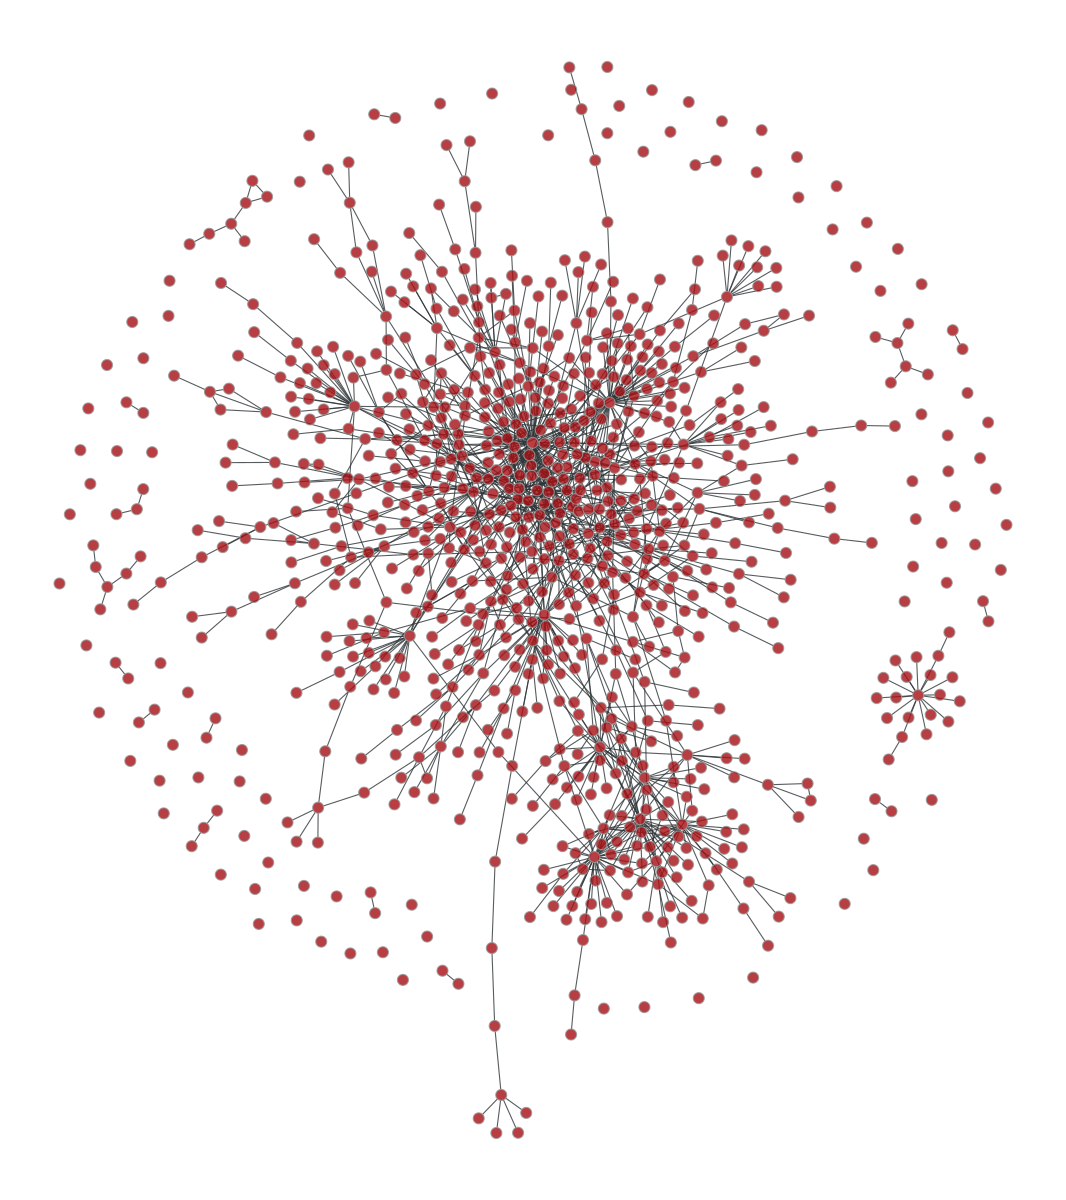

Global clustering:  0.014498356852890006 (0.014498356852890006, 0.003750499964581285)
Degree assortativity:  -0.15721206469700127 (-0.15721206469700144, 0.018677897226418667)


<Figure size 1000x1000 with 0 Axes>

In [68]:
# Plotting the network using graph-tool
plt.figure(figsize=(10,10))
gt.graph_draw(g)

# Calculating the clustering and assotativity using networkx and graph-tool
print("Global clustering: ", nx.transitivity(G), clustering.global_clustering(g, sampled=False))
print("Degree assortativity: ", nx.assortativity.degree_assortativity_coefficient(G), correlations.scalar_assortativity(g, "total"))

### Define all possible edges (all N^2 combination of nodes)

We are trying to predict which one of those edges exist, and which don't. We are going to use the network structure to predict this.

- df_edgelist: list of possible edges with labels: We will use this dataset to train the model.
- df_test: list of potential edges (50% that acutally exist, 50% that do not exist). We will use this dataset to test the predictions.

- Columns of both datasets:
    - 0: source node
    - 1: target node
    - "edge": label (1 if edge exists, 0 if edge does not exist)

In [69]:
# create dataframe all possible edges in theory (N*(N-1))
all_edges_gt = list(product(range(g.num_vertices()), repeat=2))
all_edges_nx = list(product(G.nodes(), repeat=2))
df_edgelist = pd.DataFrame([vi for vi in all_edges_gt])
display(df_edgelist.head())

# Convert the nodes names to have the same names as we had in networkx
df_edgelist[0] = df_edgelist[0].map(gt_to_networkx_labels)
df_edgelist[1] = df_edgelist[1].map(gt_to_networkx_labels)
df_edgelist.head()

# Merge with dataframe with actual links to create dummy variable (link / no link)
df_pos = pd.DataFrame(G.edges())
df_pos["edge"] = 1
df_edgelist = pd.merge(df_edgelist, df_pos, how="left")
df_edgelist["edge"] = df_edgelist["edge"].fillna(0) #the ones that were not present in df_pos represent absence of links
display(df_edgelist.head())

df_edgelist_no_self_loops = df_edgelist[df_edgelist[0] != df_edgelist[1]]

# Read test dataset (we will be testing our predictions on this one. Do not use this data for anything else)
df_test = pd.read_csv(f"{path_data}/{network}_network_prediction_test.csv", sep="\t", index_col=0)
df_test.columns = [0,1,"label"]
if network == "twitter":
    df_test[0] = df_test[0].astype(str)
    df_test[1] = df_test[1].astype(str)
# Drop duplicates (oops)
df_test = df_test.drop_duplicates(subset=[0,1])
df_test.head()

,0,1
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


,0,1,edge
0,0,0,0.0
1,0,1,1.0
2,0,2,0.0
3,0,439,1.0
4,0,8,1.0


,0,1,label
0,191,60,1
1,327,409,1
2,152,245,1
3,266,799,1
4,511,26,1


### Define the function to test our predictions

In [70]:
def create_predictions(df_edgelist, df_test, columns = None, return_test = False, solver="lbfgs"):
    """
    Train a LogisticRegression given the labels from df_all_pairs and the scores from df_s. 
    The model is evaluated in the test dataset

    Input:
    - df_edgelist: Columns 0,1,edge (edge = presence of a link in the training data (the graph)), variables to use as predictors
    - df_ test: Columns 0,1, link (link = presence of a link in the test data (the actual graph))
    - return_test: if True, return the test dataset with the predictions
    - columns: list of columns to use as predictors
    - solver: solver to use in the LogisticRegression 

    Output:
    - If return_test is True, return the test dataset with the predictions
    - If return_test if False, return the predicted probabilities of all potential links
    """
    if columns is None:
        # Use all columns except the first two as independent variables (the first two are the labels)
        columns = list(df_edgelist.columns)[3:]

    # Create model and fit using cross-validation
    model = LogisticRegressionCV(cv=5, max_iter=1000,
                                  class_weight="balanced", n_jobs=-1, scoring="f1",
                                  solver=solver)
    
    # Remove self-loops (not necessarily what you want to do always, espcially in biological networks)
    df_edgelist = df_edgelist.loc[df_edgelist[0] != df_edgelist[1]]

    # Scale features
    X = df_edgelist[columns]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model.fit(X, df_edgelist["edge"])
    print(f"Intercept: {model.intercept_[0]: 2.2f}")
    for var, col in zip(columns, model.coef_[0]):
        print(f"{var}: {col: 2.2f}")

    # Predict labels for all pairs
    df_edgelist["pred"] = model.predict(X)

    # Merge the predictions with the test dataset to evaluate the prediction
    df_test = pd.merge(df_test, df_edgelist, on=[0,1], how="inner", validate="1:1")

    #recall = ability of the classifier to find all the positive samples.
    #precision = ability of the classifier not to label as positive a sample that is negative.
    print(classification_report(df_test["label"], df_test["pred"]))

    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, scaler.transform(df_test[columns]), df_test["label"]) 
    plt.plot([0,1], [0,1], "--", color="lightgray", zorder=0)
    plt.grid(True)

    if return_test:
        df_test["pred_prob"] = model.predict_proba(scaler.transform(df_test[columns]))[:,1]
        return df_test
    
    # return predicted probabilities
    return model.predict_proba(X)[:,1]



## 2. Methods based on similarity

The following methods calculate node similarity looking mostly at (variations of) common neighbors.

In graph-tool, this is done with the function s_jaccard = gt.vertex_similarity(g, "jaccard"): https://graph-tool.skewed.de/static/doc/topology.html#graph_tool.topology.vertex_similarity



In [71]:
# Calculate jaccard similarity, convert to dataframe (cols 0 and 1 are the node ids)
## calculate jaccard similarity and convert to an array
s_jaccard = gt.vertex_similarity(g, "jaccard")

df_edgelist2 = df_edgelist.copy()

# add a column with the jaccard similarity between node pairs
df_edgelist2['jaccard_score'] = np.array([s_jaccard[i] for i in range(num_vertices)]).reshape(-1)
df_edgelist2['jaccard_score'] = df_edgelist2['jaccard_score'].fillna(0) #there are somehow missing values (self-loops, but not only)

## You can change the "jaccard" argument to create a new metric
#gt.vertex_similarity?

/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Intercept: -0.01
jaccard_score:  0.13
              precision    recall  f1-score   support

           0       0.53      0.99      0.69       297
           1       0.95      0.13      0.23       297

    accuracy                           0.56       594
   macro avg       0.74      0.56      0.46       594
weighted avg       0.74      0.56      0.46       594



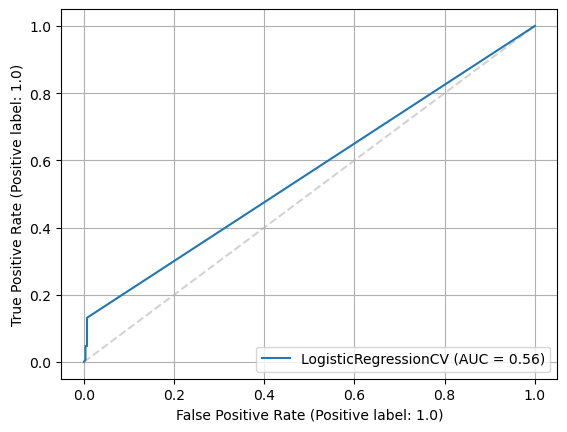

In [72]:
# Create predictions. This function will try to use the columns in the `jaccard` dataframe to predict the link
prob_jac = create_predictions(df_edgelist2, df_test, columns=["jaccard_score"])

# # save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["jaccard"] = prob_jac

### You can try some methods from here as well
https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html

For example maybe nodes link proportionally to their degree

In [73]:
# Calculate pref attachment --> Returns the name of the two nodes, and the product of the degree
pa = nx.preferential_attachment(G, all_edges_nx)
df_pa = pd.DataFrame(list(pa))
df_pa.columns = [0,1,"pa_score"]

df_edgelist2 = pd.merge(df_edgelist, df_pa, how="left", on=[0,1], validate="1:1")

Intercept: -0.52
pa_score:  1.31
              precision    recall  f1-score   support

           0       0.62      0.93      0.74       297
           1       0.86      0.43      0.57       297

    accuracy                           0.68       594
   macro avg       0.74      0.68      0.66       594
weighted avg       0.74      0.68      0.66       594



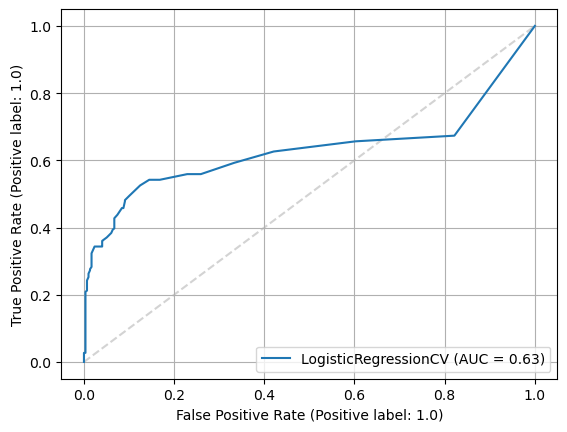

In [74]:
# create predictions as before
prob_jac = create_predictions(df_edgelist2, df_test, columns=["pa_score"])
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["pa"] = prob_jac

## 3. Methods based on paths
There are also methods that look not only at immediate neighbors, but also at longer-paths. You can do this using matrix multiplication (remember that A^2 represents the number of paths between i and j in two steps)


In [75]:
A = nx.to_numpy_array(G)

#Make higher order powers
A2 = (A @ A)
np.fill_diagonal(A2, 0)
A3 = (A2 @ A)
np.fill_diagonal(A3, 0)
A4 = (A3 @ A)
np.fill_diagonal(A4, 0)


# Put it into the same format as edgelist
df_edgelist2 = df_edgelist.copy()
df_edgelist2["a2"] = A2.reshape(-1)
df_edgelist2["a3"] = A3.reshape(-1)
df_edgelist2["a4"] = A4.reshape(-1)


Intercept: -0.75
a2:  0.22
a3:  1.30
a4: -0.57
              precision    recall  f1-score   support

           0       0.61      0.95      0.74       297
           1       0.89      0.38      0.53       297

    accuracy                           0.67       594
   macro avg       0.75      0.67      0.64       594
weighted avg       0.75      0.67      0.64       594



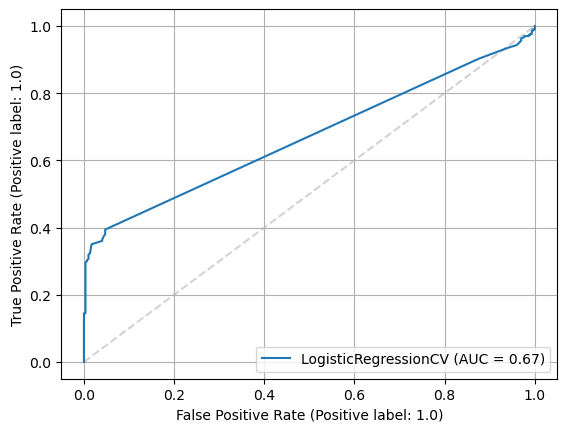

In [76]:
# create predictions
prob_jac = create_predictions(df_edgelist2, df_test, columns=["a2", "a3", "a4"])
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["paths"] = prob_jac

A more sophisticated method is Katz similarity. The Katz Similarity between two nodes i and j is the sum of the number of walks of __all lengths__ between i and j, but the walks are weighted exponentially decreasing weights based on their lengths. The intuition is that a higher number of short walks between two nodes indicate a stronger connection.

For some reason it does not work for the PPI network

In [77]:
def create_katz(g, beta):
    #Katz score (solving using algebra)
    #beta=decay parameter (paths of longer length are weighted less)
    I = np.identity(g.num_vertices()) #create identity matrix
    ks = inv(I - gt.adjacency(g)*beta) - I
    return np.array(ks.real)


# Set \beta to 1/the largest eigenvector of the Laplacian 
# (https://stackoverflow.com/questions/62069781/how-to-find-the-similarity-between-pair-of-vertices-using-katz-index-in-python)
L = gt.laplacian(g, norm=True)
e = np.linalg.eigvals(L.todense())
print("Largest eigenvalue:", max(e))
beta = 1/max(e)
# You could use different levels of beta (all below to 1, otherwise you weight longer paths more)
# Calculate katz similarity
ks = create_katz(g, beta)
np.max(ks)

# Put it into a nice format
df_edgelist2 = df_edgelist.copy()
df_edgelist2["katz"] = ks.reshape(-1)

Largest eigenvalue: (2.000000000000019+0j)


/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Intercept: -0.00
katz:  0.03
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       297
           1       1.00      0.00      0.01       297

    accuracy                           0.50       594
   macro avg       0.75      0.50      0.34       594
weighted avg       0.75      0.50      0.34       594



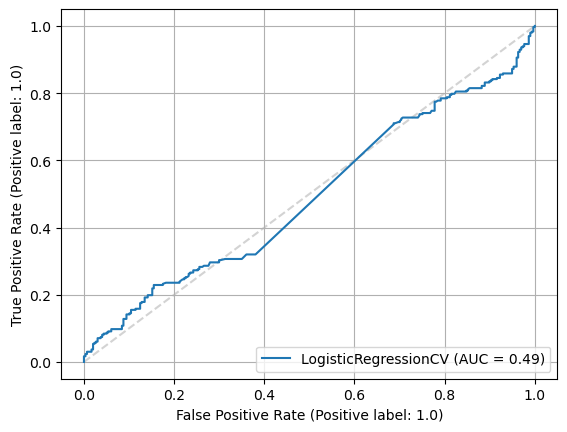

In [79]:
# create predictions (solver="saga" is slower, but converges)
prob_jac = create_predictions(df_edgelist2, df_test, columns=["katz"])#, solver="saga")
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["katz"] = prob_jac

## 4. Methods based on node embeddings (spectral methods and matrix factorization; node2vec)
The following methods will create node embeddings based on:
- spectral method and matrix factorization
- random walks and shallow networks

In order to predict a link, each pair of embeddings needs to be combined (e.g. by computing the L1 norm (np.abs(v1-v2))

* 4.1 shows an example of a spectral method (you can try different methods: TruncatedSVD, PCA, SpectralEmbedding and NMF; you can modify the dimension of the embedding as well)
* 4.2 shows an example of node2vec (you can change the p and q parameters, the length of walks, etc)




In [80]:
def calculate_dist(v1, v2):
    """
    Calculate the L1 distance between two embeddings
    (you could use a different formula, such as (v1*v2))
    """
    #I'm taking the sum, but you could let a downstream model find that out
    return np.sum(np.abs(v1 - v2))

def create_pair_distance(embeddings, G, fun_distance=calculate_dist):
    """
    Calculates the distance between embeddings using calculate_dist
    """
    # Create dictionary with embeddings
    df_clsvd = pd.DataFrame(embeddings)
    df_clsvd.index = G.nodes()
    df_clsvd = {k: row.values for k,row in df_clsvd.iterrows()}


    # Calculate all distances and convert to dictionary
    pairs = combinations(G.nodes(), 2)
    all_pairs = [fun_distance(df_clsvd[n1], df_clsvd[n2]) for n1,n2 in pairs]

    # Concatenate labels with node pairs      
    all_pairs = pd.DataFrame(all_pairs)
    all_pairs =  pd.concat([pd.DataFrame(combinations(G.nodes(), 2)), all_pairs.reset_index(drop=True)], axis=1)
    all_pairs.columns = [0,1]+[f"_{i}" for i in range(2, len(all_pairs.columns))]

    # Add the reverse of the node pair
    all_pairs = pd.concat([all_pairs, all_pairs.rename(columns={0:1, 1:0})])

    return all_pairs

### 4.1 Example with SVD
Try also PCA, SpectralEmbedding and NMF 

Try different time of embeddings sizes (n_components)

In [81]:
A = nx.to_numpy_array(G)
clusters_svd = TruncatedSVD(n_components=10)
clusters_svd.fit(A)
cl_svd = clusters_svd.components_.T

# clusters_svd = SpectralEmbedding(affinity = 'precomputed', n_components=5)
# clusters_svd.fit(A)
# cl_svd = clusters_svd.embedding_

In [82]:
df_emb = create_pair_distance(cl_svd, G)
df_emb.columns = [0, 1, "svd"]

# Self-loops are removed during th eprediction, so don't worry about those
df_edgelist2 = pd.merge(df_edgelist, df_emb, on=[0,1], how="left", validate="1:1")
df_edgelist2.head()

#You can try to modify calculate_dist

/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,0,1,edge,svd
0,0,0,0.0,NaN
1,0,1,1.0,1.934442
2,0,2,0.0,2.003521
3,0,439,1.0,2.043365
4,0,8,1.0,2.016076


Intercept: -0.27
svd:  0.50
              precision    recall  f1-score   support

           0       0.63      0.87      0.73       297
           1       0.79      0.49      0.61       297

    accuracy                           0.68       594
   macro avg       0.71      0.68      0.67       594
weighted avg       0.71      0.68      0.67       594



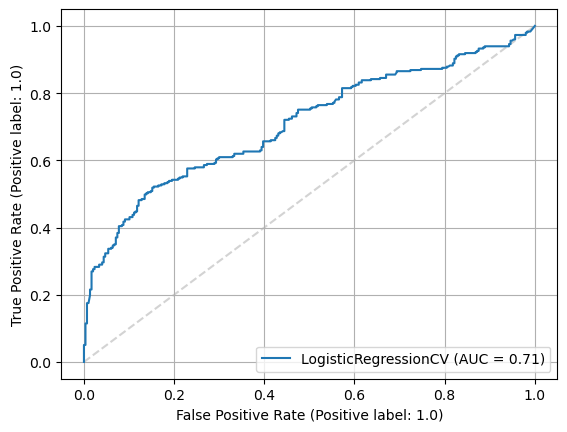

In [83]:
probs = create_predictions(df_edgelist2, df_test, columns=["svd"])
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["svd"] = probs

## 4.2 Example with node2vec

You can create and save more predictions by changing the q and p parameters

In [84]:
# Generate walks
from node2vec import Node2Vec
import gensim

dimensions = 32
workers = 8
node2vec = Node2Vec(G, dimensions=64, q=0.5, walk_length=30, num_walks=10, workers=8)  


# Embed nodes (dimensions = embedding size)
model = node2vec.fit(window=5, min_count=1, batch_words=4) 
#model = gensim.models.Word2Vec(vector_size = 32, workers=8, window=5, min_count=1, batch_words=4)

# Embeddings as a pandas dataframe
node2vec = pd.DataFrame([model.wv.get_vector(str(_)) for _ in G.nodes()])
node2vec.head()

Computing transition probabilities:   0%|          | 0/964 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.397707,-0.137517,-0.120654,0.121724,0.452133,-0.099597,0.553918,0.072111,-0.441841,-0.006454,...,0.228221,0.137468,0.726772,-0.466078,0.088232,0.010696,-0.279439,0.174572,-0.233805,0.050884
1,-0.000702,0.293782,0.334829,0.120487,-0.163580,-0.396117,0.261197,0.461232,-0.317859,-0.376816,...,0.502977,0.604549,-0.171161,-0.811811,0.193676,-0.189100,-0.272112,-0.256006,0.138851,-0.060149
2,0.516190,-0.538827,0.232902,0.270029,-0.075766,0.586305,-0.043422,0.655967,-0.913500,-0.336190,...,0.240527,-0.233500,0.517170,-0.415776,-0.358476,-0.171080,-0.265943,-0.279325,-0.034855,0.485793
3,0.991534,0.103183,0.036786,-0.085069,0.237883,-0.516749,0.460113,0.062405,-0.602179,-0.019473,...,0.500237,-0.027474,0.769426,-0.625708,-0.118275,-0.054213,-0.346324,0.293803,-0.230896,0.187350
4,0.478765,0.074616,0.405723,-0.341986,-0.138720,-0.149819,0.719784,0.415097,-0.666618,0.306246,...,0.416421,0.156494,0.643143,-0.604390,-0.307860,0.548978,-0.254348,0.375985,-0.412546,-0.147747


In [85]:
# Create all distances
df_emb = create_pair_distance(node2vec, G)
df_emb.columns = [0, 1, "node2vec"]

# Self-loops are removed during th eprediction, so don't worry about those
df_edgelist2 = pd.merge(df_edgelist, df_emb, on=[0,1], how="left", validate="1:1")
df_edgelist2.head()


,0,1,edge,node2vec
0,0,0,0.0,NaN
1,0,1,1.0,17.312752
2,0,2,0.0,23.551519
3,0,439,1.0,10.304453
4,0,8,1.0,16.687359


Intercept: -4.37
node2vec: -2.68
              precision    recall  f1-score   support

           0       0.55      0.97      0.70       297
           1       0.86      0.21      0.34       297

    accuracy                           0.59       594
   macro avg       0.71      0.59      0.52       594
weighted avg       0.71      0.59      0.52       594



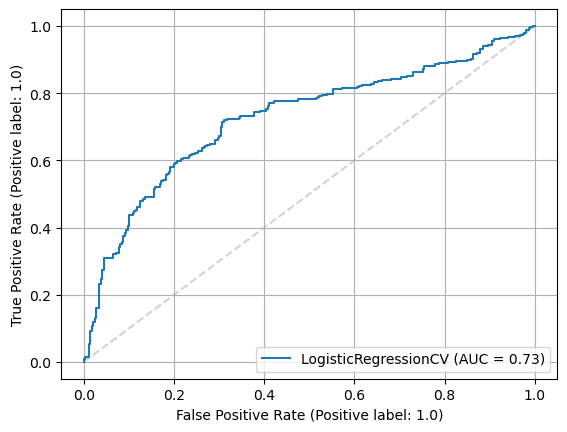

In [86]:
# Caulate predictions
probs = create_predictions(df_edgelist2, df_test, ["node2vec"])
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["node2vec"] = probs

# 5. Stacking classifiers
For each method we fitted a logisticregression, which returned a probability of two nodes being connected. 

We can now fit a meta-classifier, which takes those predictions and combines them in order to (hopefully) create a better classifier.

You can try different algorithms apart from LogisticRegressionCV: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning


In [87]:
df_edgelist2 = df_edgelist_no_self_loops.loc[:, [0,1]+["jaccard","paths","katz","svd","node2vec","pa"]]
df_edgelist2.head()

,0,1,jaccard,paths,katz,svd,node2vec,pa
1,0,1,0.510659,1.000000,0.498964,0.961935,0.670069,1.000000
2,0,2,0.495121,0.952929,0.498964,0.966716,0.063966,1.000000
3,0,439,0.495121,0.304330,0.498964,0.969205,0.989214,0.957369
4,0,8,0.495121,1.000000,0.498964,0.967521,0.740487,1.000000
5,0,9,0.495121,0.125029,0.498964,0.968276,0.029103,0.999985


Intercept: -20.05
jaccard: -0.53
pa:  2.57
paths:  0.34
katz:  0.01
svd:  0.18
node2vec:  4.72
              precision    recall  f1-score   support

           0       0.56      0.99      0.72       297
           1       0.96      0.22      0.36       297

    accuracy                           0.61       594
   macro avg       0.76      0.61      0.54       594
weighted avg       0.76      0.61      0.54       594



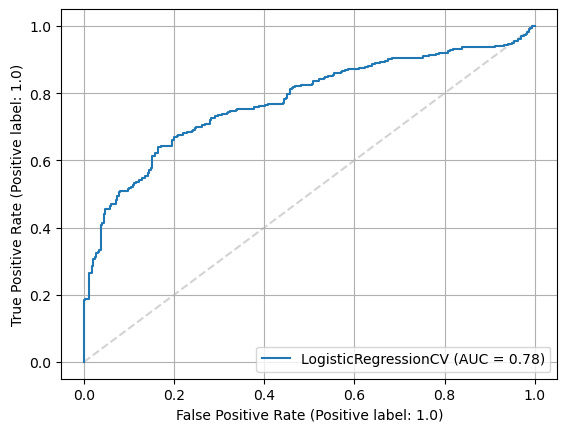

In [88]:
df_test_stack = create_predictions(df_edgelist_no_self_loops, df_test, return_test=True)

In [89]:
#Link prediction can be hard!

# 6. Explore some of the node pairs with the highest probability of a link
You can look at our results and explore which proteins may be interacting 

e.g. using the test dataset (you can also find the ones with the highest probability of being a link in the full dataset)

In [96]:
# Create a dictionary to go from the node index to the text label
d_conv_inv = nx.get_node_attributes(G, "label")
df_test_stack["source"] = df_test_stack[0].map(d_conv_inv)
df_test_stack["target"] = df_test_stack[1].map(d_conv_inv)


# Edges that are not known but are predicted as links
display(df_test_stack
    .loc[(df_test_stack["edge"]==0)  & 
         (df_test_stack["label"]!=1) &  
         (df_test_stack["node2vec"]>0.6)]
    .sort_values(by="pred_prob", ascending=False)
    .head(20)
)

,0,1,label,edge,jaccard,pa,paths,katz,svd,node2vec,pred,pred_prob,source,target
425,616,511,0,0.0,0.495121,0.291824,0.304330,0.498964,0.338947,0.999942,1.0,0.856041,YMR316W,YJR021C
375,782,773,0,0.0,0.495121,0.291824,0.304330,0.498964,0.338947,0.999940,1.0,0.856035,YOR028C,YMR117C
345,571,876,0,0.0,0.495121,0.291824,0.304330,0.498964,0.338947,0.999940,1.0,0.856034,YFR027W,YIL051C
549,36,536,0,0.0,0.567549,0.397433,0.554334,0.498964,0.355835,0.776630,0.0,0.110510,YLR345W,YPL151C
319,440,859,0,0.0,0.495121,0.291824,0.304330,0.498964,0.468988,0.834536,0.0,0.101043,YJR057W,YLL017W
316,776,560,0,0.0,0.495121,0.316706,0.222181,0.498964,0.365339,0.801503,0.0,0.048655,YMR298W,YCR021C
376,654,446,0,0.0,0.495121,0.316706,0.772724,0.498964,0.477987,0.672293,0.0,0.017627,YJR022W,YOL143C
460,788,453,0,0.0,0.495121,0.291824,0.304330,0.498964,0.468988,0.751251,0.0,0.013359,YPR193C,YOR232W
401,636,628,0,0.0,0.758777,0.316706,0.106583,0.498964,0.341600,0.954401,0.0,0.007893,YMR059W,YLL049W
512,353,538,0,0.0,0.495121,0.304122,0.536241,0.498964,0.416832,0.670112,0.0,0.004802,YGR144W,YIL105WA


In [98]:
#d_conv_inv[776], d_conv_inv[560]

https://yeastgenome.org/locus/YMR298W Ceramide synthase subunit; single-span ER membrane protein associated with Lag1p and Lac1p and __required for ceramide synthase activity__, null mutant grows extremely slowly and is defective in ceramide synthesis 1 

https://yeastgenome.org/locus/YCR021C (Heat Shock Protein)  Negative regulator of the H(+)-ATPase Pma1p; stress-responsive protein; hydrophobic plasma membrane localized; induced by heat shock, ethanol treatment, weak organic acid, glucose limitation, and entry into stationary phase 1 2 3 4 5 6 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3974757/
We find that __during heat stress distinct metabolic mechanisms control the abundance of different groups of ceramide species__. Additionally, distinct groups of ceramide species regulated different sets of functionally related genes, indicating that specific sub-groups of lipids participated in different regulatory pathways. These results indicate a previously unrecognized complexity and versatility of lipid-mediated cell regulation.

# 7. Example of Graph Neural Networks (graphSAGE )

The power of GNNs comes from their ability to use the structure of the graph, and the relationships between nodes, to improve their predictions or understanding of the data. They work by updating each node's features based on the features of its neighbors, allowing information to flow across the graph. This is particularly useful when we want to understand the context of a node, as defined by its location within a larger network.

In [56]:
# Imports
import pandas as pd
import numpy as np
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch.utils.data import DataLoader

import dgl
#import dgl.nn as dglnn
#from dgl.data.utils import save_graphs, load_graphs
#import dgl.function as fn
from dgl.nn import SAGEConv

Let's create the data (this is exactly the same code used above, with the same random seed). Don't worry about this code. It's a bit too convoluted.

In [55]:

# Set up a seed for replicability
np.random.seed(1546)

# Load data based on network type
network = "ppi"  # Example, set the network type

if network == "ppi":
    # Download PPI network
    df = pd.read_csv("https://github.com/jgarciab/NetworkScience/raw/main/Data/CCSB-Y2H.txt", skiprows=1, sep="\t", header=None)     
else:
    # Load Twitter data
    df = pd.read_csv("https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/ic2s2_netsci_3.tsv", sep="\t", usecols=["source", "target"])
    df.columns = [0, 1]

# Create bidirectional edges and remove self-loops
df = pd.concat([df, df.rename(columns={0: 1, 1: 0})])
G = nx.from_pandas_edgelist(df, source=0, target=1)
G.remove_edges_from(nx.selfloop_edges(G))

# Keep largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

# Convert network back to DataFrame and relabel nodes
df = pd.DataFrame(G.edges())
df = pd.concat([df, df.rename(columns={0: 1, 1: 0})]).drop_duplicates()
nodes = df[0].unique()
d_conv = dict(zip(nodes, range(len(nodes))))
df[0] = df[0].map(d_conv)
df[1] = df[1].map(d_conv)

# Create graph and adjacency matrix
G = nx.from_pandas_edgelist(df, source=0, target=1)
adj = nx.to_scipy_sparse_array(G, nodelist=range(len(G)))

# Split edges into train/test sets
u, v = np.nonzero(adj)
eids = np.random.permutation(len(u))
test_size = int(len(eids) * 0.1)
train_pos_u, test_pos_u = u[eids[test_size:]], u[eids[:test_size]]
train_pos_v, test_pos_v = v[eids[test_size:]], v[eids[:test_size]]

# Find negative edges and split them into train/test sets
adj_neg = adj.todense() + np.eye(len(G)) - 1
neg_u, neg_v = np.nonzero(adj_neg)
neg_eids = np.random.choice(len(neg_u), len(u))
train_neg_u, test_neg_u = neg_u[neg_eids[test_size:]], neg_u[neg_eids[:test_size]]
train_neg_v, test_neg_v = neg_v[neg_eids[test_size:]], neg_v[neg_eids[:test_size]]


In [57]:
# Create DGL graph and features
g = dgl.graph((df[0].values, df[1].values))
g.ndata['feat'] = F.one_hot(g.nodes(), num_classes=g.number_of_nodes()).float()

# Remove edges in the test dataset
train_g = dgl.remove_edges(g, eids[:test_size])

# Create DGL graphs for training and testing
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())
all_neg_g = dgl.graph((neg_u, neg_v), num_nodes=g.number_of_nodes())


In [58]:
# Define GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Define MLP predictor
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)


In [59]:
# Set up the model and optimizer
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
pred = MLPPredictor(16)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# Training loop
for epoch in range(25):
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        with torch.no_grad():
            pos_score = pred(test_pos_g, h)
            neg_score = pred(test_neg_g, h)
            print(f'AUC in testing: {compute_auc(pos_score, neg_score)}')
    

Epoch 0, Loss: 0.6980016827583313
AUC in testing: 0.500753891326282
Epoch 1, Loss: 0.6907779574394226
AUC in testing: 0.5675838066410457
Epoch 2, Loss: 0.6845378279685974
AUC in testing: 0.6396116042580688
Epoch 3, Loss: 0.6769359111785889
AUC in testing: 0.6964255348093733
Epoch 4, Loss: 0.6655728816986084
AUC in testing: 0.7350043646339944
Epoch 5, Loss: 0.6484914422035217
AUC in testing: 0.7645818453899262
Epoch 6, Loss: 0.6255501508712769
AUC in testing: 0.7858381797775738
Epoch 7, Loss: 0.598031222820282
AUC in testing: 0.8012787810767608
Epoch 8, Loss: 0.5677509903907776
AUC in testing: 0.8137605006291875
Epoch 9, Loss: 0.5346354246139526
AUC in testing: 0.8225011053293881
Epoch 10, Loss: 0.49919721484184265
AUC in testing: 0.8301307122855943
Epoch 11, Loss: 0.4655056297779083
AUC in testing: 0.8357310478522599
Epoch 12, Loss: 0.4376629590988159
AUC in testing: 0.8396535500912605
Epoch 13, Loss: 0.4158407151699066
AUC in testing: 0.8417508417508418
Epoch 14, Loss: 0.4012602567672

              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71       297
         1.0       0.71      0.73      0.72       297

    accuracy                           0.71       594
   macro avg       0.71      0.71      0.71       594
weighted avg       0.71      0.71      0.71       594



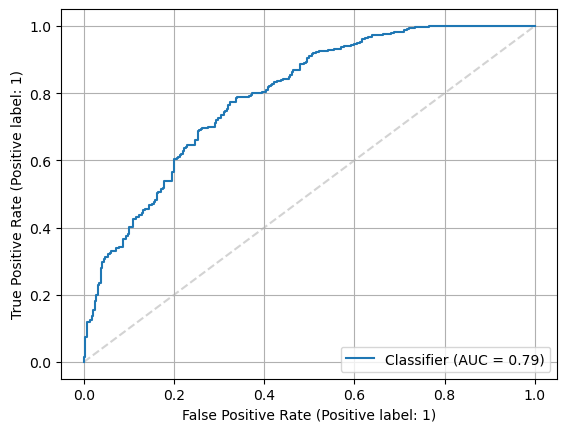

In [64]:
# After training, prepare the test DataFrame
df_test = pd.DataFrame({
    'source': np.concatenate([test_pos_u, test_neg_u]),
    'target': np.concatenate([test_pos_v, test_neg_v]),
    'label': np.concatenate([np.ones(len(test_pos_u)), np.zeros(len(test_neg_u))])
})

# Add predictions to the test DataFrame
with torch.no_grad():
    pos_score = pred(test_pos_g, h).numpy()
    neg_score = pred(test_neg_g, h).numpy()
    df_test["pred"] = np.concatenate([pos_score, neg_score])

# Map integer node labels back to original labels
d_conv_inv = {v: k for k, v in d_conv.items()}
df_test["source"] = df_test["source"].map(d_conv_inv)
df_test["target"] = df_test["target"].map(d_conv_inv)


# Plot ROC curve
RocCurveDisplay.from_predictions(df_test["label"], df_test["pred"])
plt.plot([0,1], [0,1], "--", color="lightgray", zorder=0)
plt.grid(True)

print(classification_report(df_test["label"], df_test["pred"] > 0))


In [66]:

# Print top 20 predictions
print(df_test.loc[df_test["label"]==0].sort_values(by="pred", ascending=False).head(20))

      source    target  label      pred
393  YPL004C   YDR510W    0.0  5.631856
523  YJL006C   YBR052C    0.0  4.616758
378  YPL094C   YDR124W    0.0  4.278125
423  YOR379C   YGL244W    0.0  4.244310
392  YKL033W   YOL034W    0.0  4.160445
588  YAR028W   YBR052C    0.0  4.118565
531  YGR142W   YER128W    0.0  3.987503
461  YBL078C   YFL039C    0.0  3.725068
302  YOR379C   YMR227C    0.0  3.646218
455  YCL028W   YOR174W    0.0  3.530458
431  YOR370C   YDR353W    0.0  3.500742
479  YPR135W   YNL286W    0.0  3.256854
467  YKL171W   YJL218W    0.0  3.122080
548  YGL181W   YNL316C    0.0  3.005828
413  YNR034W  YLR438CA    0.0  2.985767
361  YDR284C   YHR084W    0.0  2.979533
520  YDL195W   YDR100W    0.0  2.917517
322  YDR146C   YGR142W    0.0  2.831634
381  YGR233C   YDL005C    0.0  2.820141
309  YKL025C   YGR142W    0.0  2.793962


https://yeastgenome.org/locus/YKL033W
Subunit of the ASTRA complex, involved in chromatin remodeling; __telomere length regulator__ involved in the stability or biogenesis of PIKKs such as TORC1; similar to S. pombe Tti1p; detected in highly purified mitochondria in high-throughput studies 1

https://yeastgenome.org/locus/YOL034W
Subunit of the SMC5-SMC6 complex; the SMC5-SMC6 complex __plays a key role in the removal of X-shaped DNA structures that arise between sister chromatids during DNA replication and repair__; binds single-stranded DNA and has ATPase activity; supports nucleolar function; S. pombe homolog forms a heterodimer with S. pombe Rad18p that is involved in DNA repai

## This is how we created the network

In [230]:


def create_network_train_test(df, net_name="twitter"):
    df = pd.concat([df, df.rename(columns={0:1, 1:0})])

    G = nx.from_pandas_edgelist(df, source=0, target=1)
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    df = pd.DataFrame(G0.edges())
    df = pd.concat([df, df.rename(columns={0:1, 1:0})]).drop_duplicates()

    nodes = df[0].unique()
    d_conv = dict(zip(nodes, range(len(nodes))))
    df[0] = df[0].map(d_conv)
    df[1] = df[1].map(d_conv)

    G = nx.from_pandas_edgelist(df, source=0, target=1)

    adj = nx.to_scipy_sparse_array(G, nodelist=range(len(G)))

    u,v = np.nonzero(adj)
    eids = np.arange(len(u))
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * 0.1)
    train_size = len(u) - test_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges and split them for training and testing
    adj_neg =  adj.todense() + np.eye(len(G)) - 1
    neg_u, neg_v = np.nonzero(adj_neg)

    neg_eids = np.random.choice(len(neg_u), len(u))
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
    # Positive and negative examples to test (50-50)
    pos = pd.DataFrame(np.array([test_pos_u,test_pos_v]).T)
    pos["label"] = 1
    neg = pd.DataFrame(np.array([test_neg_u,test_neg_v]).T)
    neg["label"] = 0
    df_test = pd.concat([pos,neg])
    len(df_test)

    df_test.to_csv(f"{path_data}{net_name}_network_prediction_test.csv", sep="\t")

    # Network with 10% removed
    G.remove_edges_from(zip(test_pos_u, test_pos_v))
    nx.set_node_attributes(G, {v:k for k,v in d_conv.items()}, name="label")
    nx.write_graphml(G, f"{path_data}{net_name}_network_prediction.graphml")

if 0: #don't run it
    np.random.seed(1546)
    # Create network for challenge (Twitter)
    df = pd.read_csv(f"{path_data}/ic2s2_netsci_3.tsv", sep="\t", usecols=["source", "target"])
    df.columns = [0,1]
    create_network_train_test(df, net_name="twitter")

    np.random.seed(1546)
    # Create network for challenge (PPI)
    df = pd.read_csv("http://interactome.dfci.harvard.edu/S_cerevisiae/download/CCSB-Y2H.txt",sep="\t",header=None)
    create_network_train_test(df, net_name="ppi")